# Train test split

Here we try a very simple idea of train-test split. We just split r

# Setup

In [3]:
import sys
sys.path.insert(0, '../src')
import preprocess
import utils
import random
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
from matplotlib import rc
rc('figure', figsize=(16, 8), max_open_warning=False)
from surprise import SVD, SVDpp, NMF
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import train_test_split
import pandas as pd
import numpy as np
import implicit
import codecs
import json

In [21]:
from sklearn.model_selection import train_test_split, KFold

def aminer_implicit_train_test_split(filename):
    # Now we create train test split
    # this can also be used as train-val-test
    df = pd.read_table(filename,
                             usecols=[0, 1, 2],
                             names=['user', 'ref', 'score'],
                             na_filter=False)
    train, test = train_test_split(df, test_size=0.1)
    train.to_csv(filename[:-4]+'_train.tsv',sep='\t', header=False, index=False)
    test.to_csv(filename[:-4]+'_test.tsv',sep='\t', header=False, index=False) # This should have some false entries as well???

In [22]:
aminer_implicit_train_test_split('../dblp-ref/aminer-debug.tsv')

# Implicit

In [19]:
import argparse
import codecs
import logging
import time

import numpy
import pandas
from scipy.sparse import coo_matrix

from implicit.als import AlternatingLeastSquares
from implicit.approximate_als import (AnnoyAlternatingLeastSquares, FaissAlternatingLeastSquares,
                                      NMSLibAlternatingLeastSquares)
from implicit.bpr import BayesianPersonalizedRanking
from implicit.nearest_neighbours import (BM25Recommender, CosineRecommender,
                                         TFIDFRecommender, bm25_weight)

# maps command line model argument to class name
MODELS = {"als":  AlternatingLeastSquares,
          "nmslib_als": NMSLibAlternatingLeastSquares,
          "annoy_als": AnnoyAlternatingLeastSquares,
          "faiss_als": FaissAlternatingLeastSquares,
          "tfidf": TFIDFRecommender,
          "cosine": CosineRecommender,
          "bpr": BayesianPersonalizedRanking,
          "bm25": BM25Recommender}


def get_model(model_name):
    model_class = MODELS.get(model_name)
    if not model_class:
        raise ValueError("Unknown Model '%s'" % model_name)

    # some default params
    if issubclass(model_class, AlternatingLeastSquares):
        params = {'factors': 64, 'dtype': numpy.float32, 'use_gpu': True}
    elif model_name == "bm25":
        params = {'K1': 100, 'B': 0.5}
    elif model_name == "bpr":
        params = {'factors': 63, 'use_gpu': True}
    else:
        params = {}

    return model_class(**params)


def read_data(filename):
    """ Reads in the AMINER dataset, and returns a tuple of a pandas dataframe
    and a sparse matrix of artist/user/playcount """
    # read in triples of user/artist/playcount from the input dataset
    # get a model based off the input params
    start = time.time()
    print("reading data from %s"% (filename))
    data = pandas.read_table(filename,
                             usecols=[0, 1, 2],
                             names=['user', 'ref', 'cites'],
                             na_filter=False)

    # map each artist and user to a unique numeric value
    data['user'] = data['user'].astype("category")
    data['ref'] = data['ref'].astype("category")

    # create a sparse matrix of all the users/plays
    cites = coo_matrix((data['cites'].astype(numpy.float32),
                       (data['ref'].cat.codes.copy(),
                        data['user'].cat.codes.copy())))

    print("read data file in {}".format( time.time() - start))
    return data, cites

'''
def calculate_similar_artists(input_filename, output_filename, model_name="als"):
    """ generates a list of similar artists in lastfm by utiliizing the 'similar_items'
    api of the models """
    df, plays = read_data(input_filename)

    # create a model from the input data
    model = get_model(model_name)

    # if we're training an ALS based model, weight input for last.fm
    # by bm25
    if issubclass(model.__class__, AlternatingLeastSquares):
        # lets weight these models by bm25weight.
        print("weighting matrix by bm25_weight")
        plays = bm25_weight(plays, K1=100, B=0.8)

        # also disable building approximate recommend index
        model.approximate_recommend = False

    # this is actually disturbingly expensive:
    plays = plays.tocsr()

    print("training model {}".format( model_name))
    start = time.time()
    model.fit(plays)
    print("trained model '%s' in %0.2f"%( model_name, time.time() - start))

    # write out similar artists by popularity
    artists = dict(enumerate(df['artist'].cat.categories))
    start = time.time()
    print("calculating top artists")
    user_count = df.groupby('artist').size()
    to_generate = sorted(list(artists), key=lambda x: -user_count[x])

    # write out as a TSV of artistid, otherartistid, score
    with codecs.open(output_filename, "w", "utf8") as o:
        for artistid in to_generate:
            artist = artists[artistid]
            for other, score in model.similar_items(artistid, 11):
                o.write("%s\t%s\t%s\n" % (artist, artists[other], score))

    print("generated similar artists in %0.2f"%(time.time() - start))
'''

def calculate_recommendations(input_filename, output_filename, model_name="als"):
    """ Generates artist recommendations for each user in the dataset """
    # train the model based off input params
    df, cites = read_data(input_filename)

    # create a model from the input data
    model = get_model(model_name)

    # if we're training an ALS based model, weight input for last.fm
    # by bm25
    if issubclass(model.__class__, AlternatingLeastSquares):
        # lets weight these models by bm25weight.
        print("weighting matrix by bm25_weight")
        cites = bm25_weight(cites, K1=100, B=0.8)

        # also disable building approximate recommend index
        model.approximate_similar_items = False

    # this is actually disturbingly expensive:
    cites = cites.tocsr()

    print("training model {}".format(model_name))
    start = time.time()
    model.fit(cites)
    print("trained model '%s' in %0.2f"%( model_name, time.time() - start))

    # generate recommendations for each user and write out to a file
    artists = dict(enumerate(df['ref'].cat.categories))
    start = time.time()
    user_cites = cites.T.tocsr()
    with codecs.open(output_filename, "w", "utf8") as o:
        for userid, username in enumerate(df['user'].cat.categories):
            for artistid, score in model.recommend(userid, user_cites):
                o.write("%s\t%s\t%s\n" % (username, artists[artistid], score))
    print("generated recommendations in %0.2f"%(  time.time() - start))


def start(inputfile='../dblp-ref/aminer-debug.tsv',outputfile='../output-debug.tsv', model='als'):

    #if recommend:
    calculate_recommendations(inputfile, outputfile, model_name=model)
    #else:
        #calculate_similar_artists(inputfile, outputfile, model_name=model)
       

# Run it on debug data (no train-test split)

In [23]:
!export OPENBLAS_NUM_THREADS=1
!export MKL_NUM_THREADS=1

start('../dblp-ref/aminer-debug_train.tsv', "../output_debug_train.tsv")

reading data from ../dblp-ref/aminer-debug_train.tsv


read data file in 1.9840471744537354
weighting matrix by bm25_weight
training model als
trained model 'als' in 2.27
generated recommendations in 669.22


# Result

In [24]:
visData = pd.read_table("../output_debug_train.tsv",
                             usecols=[0, 1, 2],
                             names=['user', 'ref', 'score'],
                             na_filter=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22064007f0>]], dtype=object)

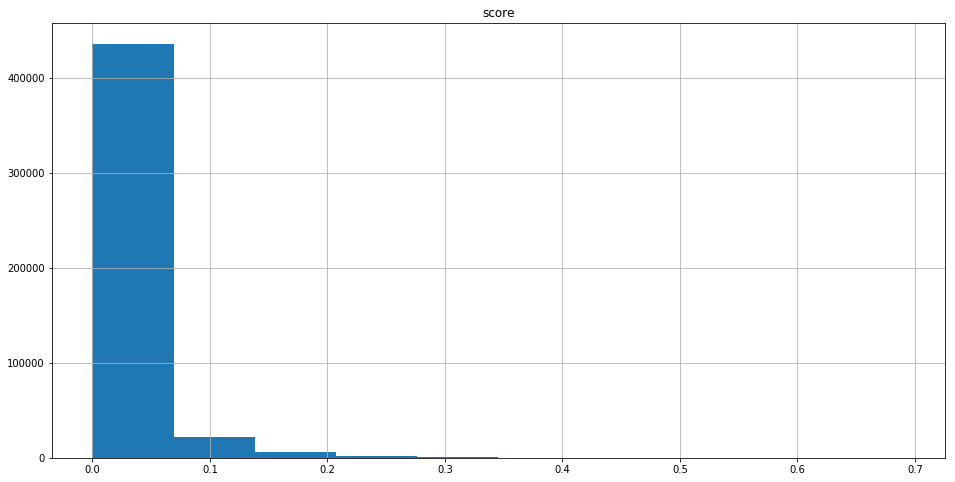

In [25]:
visData.hist("score")

In [26]:
visData.describe()

,score
count,4.671400e+05
mean,1.575254e-02
std,3.533414e-02
min,4.413880e-10
25%,4.280900e-04
50%,2.971020e-03
75%,1.219430e-02
max,6.907630e-01


In [27]:
bigger_than_point_one = visData[visData["score"]>0.1]
len(bigger_than_point_one)

17432

In [28]:
testData = pd.read_table('../dblp-ref/aminer-debug_test.tsv',
                             usecols=[0, 1, 2],
                             names=['user', 'ref', 'score'],
                             na_filter=False)

In [29]:
testData.head()

,user,ref,score
0,0f191186-dd05-44e9-910b-dbfd559f02f2,a926aa24-ddd5-4cf5-a782-f0e05a069c23,1
1,540f6443-1743-4f59-9092-465c981084d1,3d53e3c3-9855-4053-a831-8685f34ad684,1
2,342fb1f5-97d2-4ffc-b233-3019f0490c69,2bab27fa-a3ac-4649-a925-628145c17a06,1
3,ffa01122-c092-4811-bb10-eac710181eaf,7c9279c4-3479-4e51-9330-7d08d89f3b6f,1
4,83978d17-f101-407e-942d-c13814241ab7,9214e131-8dcf-437b-a5ff-213ebb0a31ec,1


In [30]:
len(testData)

60241

In [31]:
len(visData)

467140

In [33]:
# True positive
intersection = pd.merge(visData, testData, how='inner', on=['user','ref'])
len(intersection)

514

In [34]:
intersection.head()

,user,ref,score_x,score_y
0,007b3bdc-5eec-4aa0-a552-a9ab8a354968,efd512b1-ae5d-4f24-bf0c-3513d129938f,0.058090,1
1,00cf57a5-e0aa-480b-baa9-74da31d58722,109115f0-0dc5-40f3-a586-f980b0fabd8f,0.006520,1
2,00e32901-0145-434e-b16e-5e72a3e0ec24,8825334c-e029-4fc8-b560-02c71b3f238c,0.133585,1
3,00e47457-0e6c-40ce-902e-5c7d7f907ce4,fc05a29b-79dd-4dfe-9a5f-d7c7b68bf732,0.009254,1
4,0110b4a1-d912-4695-93f5-3e3d7dc1d0c6,d9b6fc3a-1508-4e5f-9211-71bdbd2530d9,0.042223,1


In [35]:
n_rel_and_rec_k = len(intersection)
n_rel = len(testData)
n_rec_k = len(visData)

precision = n_rel_and_rec_k / n_rec_k
recall = n_rel_and_rec_k / n_rel

print(precision)
print(recall)

0.0011003125401378602
0.00853239488056307


In [40]:
# PR curve
precisions, recalls = [], []
for epsilon in np.linspace(0.00001, 0.7, num=100):
    recommendation_at_k = visData[visData["score"]>epsilon]
    intersection = pd.merge(recommendation_at_k, testData, how='inner', on=['user','ref'])
    n_rel_and_rec_k = len(intersection)
    n_rel = len(testData)
    n_rec_k = len(recommendation_at_k)
    if n_rec_k == 0:
        break
    precision = n_rel_and_rec_k / n_rec_k
    recall = n_rel_and_rec_k / n_rel
    precisions.append(precision)
    recalls.append(recall)

Text(0.5,1,'PR Curve with recommendations on test data generated with train data. X axis=precision, Y axis=recall')

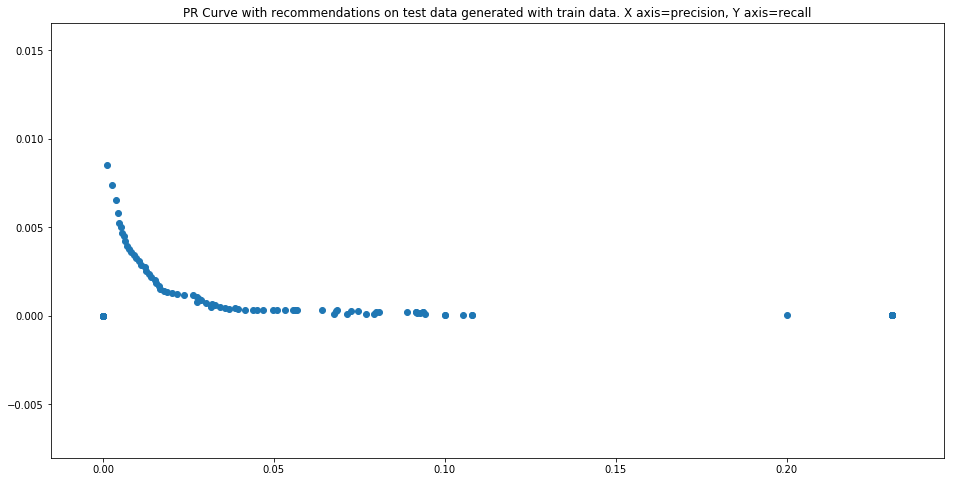

In [41]:
plt.scatter(precisions,recalls)
plt.title("PR Curve with recommendations on test data generated with train data. X axis=precision, Y axis=recall")